# 常见的优化操作和优化算法

## 1. 标准化 Normalization

### 1.1 标准化输入 Normalizing inputs 

对输入做标准化其实就是三个步骤：

1. 求训练集 $X_{train}$ 的均值 $\mu$ 和标准差 $\sigma$

2. $\frac{X_{train}-\mu}{\sigma}$

3. $\frac{X_{test}-\mu}{\sigma}$

做这一步的时候唯一要注意的就是求均值和标准差的方向。

In [1]:
import numpy as np

随机生成一个7行5列的 array ，表示一个有7个样本5个特征的数据集

In [2]:
X = np.random.random(size=(7, 5))
X

array([[0.20533739, 0.70312772, 0.83715993, 0.772887  , 0.53087653],
       [0.04994715, 0.14966868, 0.05217123, 0.43034379, 0.25431423],
       [0.61372634, 0.79138317, 0.11026665, 0.51355529, 0.16331587],
       [0.40752224, 0.49362594, 0.40189569, 0.15196024, 0.76249753],
       [0.38341049, 0.45316606, 0.31191307, 0.36740472, 0.35071331],
       [0.46853804, 0.16697988, 0.09366203, 0.82852645, 0.34986049],
       [0.33160006, 0.1136486 , 0.84048418, 0.36830454, 0.35626642]])

因为是要把每个连续特征的都标准化为均值为0标准差为1的向量，所以求均值是要求每一列的均值和标准差：

In [3]:
mu = X.mean(axis=0)
sigma = X.std(axis=0)

可以通过查看 shape 确认一下。如果不设置axis的话求的结果是一个数而不是一个向量，即整个维数组的均值和标准差。

In [4]:
mu.shape

(5L,)

标准化之后的X就是这样的。虽然 $\mu$ 和 $\sigma$ 的维度和 X 不相同，但是 numpy 会自动把它们 broadcast 到跟 X 相同的维度之后再做运算。

In [5]:
e = 1e-10
X_std = (X - mu) / (sigma + e)

### 1.2 批量标准化 batch normalization

假如全连接层输出n个向量，每个向量有p维，其实标准化的做法跟标准化输入差不多，不过MXNet的Gluon有提供现成的BatchNorm层可以直接使用。

与Drpoout层写法类似，直接在需要添加的层后面、激活函数前面插入BatchNorm层即可。

这里不需要指定输出数据的维度和特征数，系统可以通过推理得到。

In [7]:
from mxnet.gluon import nn

In [8]:
net = nn.Sequential()
net.add(
    nn.Dense(100),
    nn.BatchNorm(),
    nn.Activation('sigmoid')
)

## 2. 梯度剪裁

梯度剪裁可以保证整个模型参数梯度的L2范数不会超过 $\theta$

$$g_{clip}=min(\frac{\theta}{||g||},1)g$$

In [9]:
def grad_clipping(params, state_h, Y, theta, ctx):
    if theta is not None:
        norm = nd.array([0.0], ctx)
        for param in params:
            norm += (param.grad ** 2).sum()
        norm = norm.sqrt().asscalar()
        if norm > theta:
            for param in params:
                param.grad[:] *= theta / norm

## 3. 优化算法

先生成一个简单的数据集：X,y
$$y = 2x_1 - 3x_2 + 4$$

In [10]:
from mxnet import autograd, gluon, init, nd
from mxnet.gluon import nn, data as gdata, loss as gloss
import numpy as np

In [11]:
num_inputs = 2
num_examples = 1000
true_w = [2, -3]
true_b = 4
features = nd.random.normal(scale=1, shape=(num_examples, num_inputs))
labels = true_w[0] * features[:, 0] + true_w[1] * features[:, 1] + true_b
labels += nd.random.normal(scale=0.01, shape=labels.shape)

# 线性回归模型。
net = nn.Sequential()
net.add(nn.Dense(1))

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

In [13]:
# 绘图函数
def draw(x_value, y_value, x_axis_name, y_axis_name):
    #y_log = np.log10(y_value)
    plt.plot(x_value, y_value)
    plt.yscale('log')
    plt.xlabel(x_axis_name)
    plt.ylabel(y_axis_name)
    plt.show()

In [14]:
# 优化目标函数。
def optimize(batch_size, trainer, num_epochs, decay_epoch, log_interval,
             features, labels, net):
    dataset = gdata.ArrayDataset(features, labels)
    data_iter = gdata.DataLoader(dataset, batch_size, shuffle=True)
    loss = gloss.L2Loss()
    ls = [loss(net(features), labels).mean().asnumpy()]
    for epoch in range(1, num_epochs + 1):
        # 学习率自我衰减。
        if decay_epoch and epoch > decay_epoch:
            trainer.set_learning_rate(trainer.learning_rate * 0.1)
        for batch_i, (X, y) in enumerate(data_iter):
            with autograd.record():
                l = loss(net(X), y)
            l.backward()
            trainer.step(batch_size)
            if batch_i * batch_size % log_interval == 0:
                ls.append(loss(net(features), labels).mean().asnumpy())
    # 为了便于打印，改变输出形状并转化成numpy数组。
    print('w:', net[0].weight.data(), '\nb:', net[0].bias.data(), '\n')
    es = np.linspace(0, num_epochs, len(ls), endpoint=True)
    draw(es, ls, 'epoch', 'loss')

### 3.1 梯度下降 sgd

虽然梯度下降 gd 、随机梯度下降 sgd 和小批量随机梯度下降 mini-batch sgd 虽然叫法有细微差别，但是在 MXNet 中都是调用 'sgd'，差别在于如何设定 batch size 。 batch size=1 时就是随机梯度下降，batch size=样本总数时就是梯度下降，在这两者之间的就是小批量随机梯度下降。

3.1.1 随机梯度下降

这里设置 batch size=1 就是随机梯度下降。

('w:', 
[[ 2.0030425 -3.0084066]]
<NDArray 1x2 @cpu(0)>, '\nb:', 
[3.993155]
<NDArray 1 @cpu(0)>, '\n')


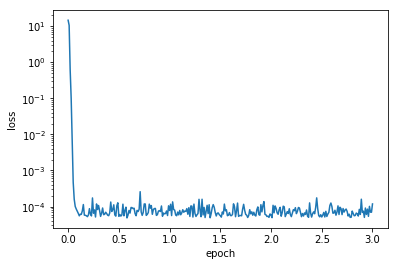

In [15]:
net.initialize(init.Normal(sigma=0.01), force_reinit=True)
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.2})
optimize(batch_size=1, trainer=trainer, num_epochs=3, decay_epoch=None,
         log_interval=10, features=features, labels=labels, net=net)

decay_epoch 表示在这个 epoch 之后做梯度衰减。log_interval 表示采了这么多样之后记录当前的 loss 值用于作图。

可以看出，当优化算法为随机梯度下降时，假如 learning rate 固定不变， loss function 的结果一直处于振荡的状态。

('w:', 
[[ 2.001102  -3.0000577]]
<NDArray 1x2 @cpu(0)>, '\nb:', 
[4.000442]
<NDArray 1 @cpu(0)>, '\n')


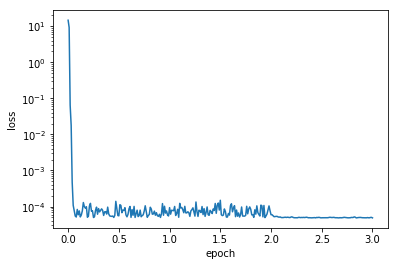

In [16]:
net.initialize(init.Normal(sigma=0.01), force_reinit=True)
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.2})
optimize(batch_size=1, trainer=trainer, num_epochs=3, decay_epoch=2,
         log_interval=10, features=features, labels=labels, net=net)

让它从第二个epoch开始做梯度衰减，振荡就会小很多

3.1.2 梯度下降

设置 batch_size=1000 （样本总数）时就是梯度下降。

('w:', 
[[ 1.0477927 -1.4677145]]
<NDArray 1x2 @cpu(0)>, '\nb:', 
[1.9411317]
<NDArray 1 @cpu(0)>, '\n')


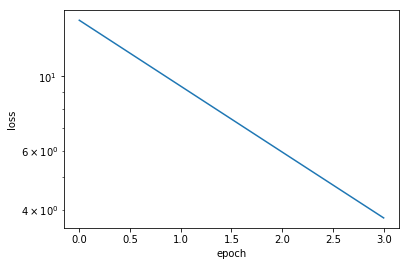

In [17]:
net.initialize(init.Normal(sigma=0.01), force_reinit=True)
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.2})
optimize(batch_size=1000, trainer=trainer, num_epochs=3, decay_epoch=None,
         log_interval=10, features=features, labels=labels, net=net)

('w:', 
[[ 2.0533788 -3.0341868]]
<NDArray 1x2 @cpu(0)>, '\nb:', 
[4.0275555]
<NDArray 1 @cpu(0)>, '\n')


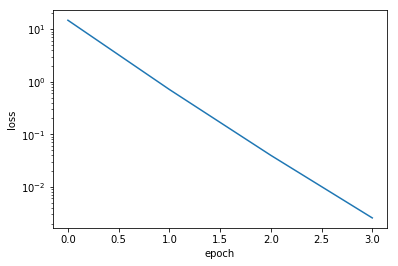

In [18]:
net.initialize(init.Normal(sigma=0.01), force_reinit=True)
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 1.2})
optimize(batch_size=1000, trainer=trainer, num_epochs=3, decay_epoch=None,
         log_interval=10, features=features, labels=labels, net=net)

做梯度下降的时候，只要learning rate不是大得离谱，就不需要在梯度下降的时候自我衰减学习率。

('w:', 
[[ 32.933975 -36.41736 ]]
<NDArray 1x2 @cpu(0)>, '\nb:', 
[45.216354]
<NDArray 1 @cpu(0)>, '\n')


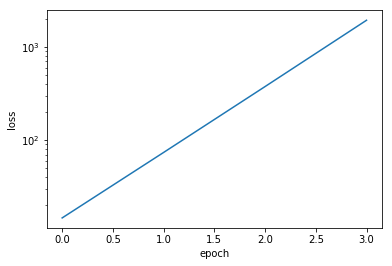

In [19]:
net.initialize(init.Normal(sigma=0.01), force_reinit=True)
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 3.2})
optimize(batch_size=1000, trainer=trainer, num_epochs=3, decay_epoch=None,
         log_interval=10, features=features, labels=labels, net=net)

当 learning rate 过大时，模型参数容易越过最优解，导致 loss 的值越来越大。

3.1.3 小批量随机梯度下降

('w:', 
[[ 1.9817816 -2.9586377]]
<NDArray 1x2 @cpu(0)>, '\nb:', 
[3.9416158]
<NDArray 1 @cpu(0)>, '\n')


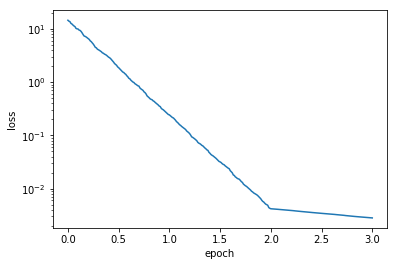

In [20]:
net.initialize(init.Normal(sigma=0.01), force_reinit=True)
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.02})
optimize(batch_size=10, trainer=trainer, num_epochs=3, decay_epoch=2,
         log_interval=10, features=features, labels=labels, net=net)

### 3.2 动量法

要使用动量法，只要在 Trainer 中给 momentum 赋值就行。这里的 momentum 就是 $\gamma$

('w:', 
[[-56.467583  18.489109]]
<NDArray 1x2 @cpu(0)>, '\nb:', 
[-13.356575]
<NDArray 1 @cpu(0)>, '\n')


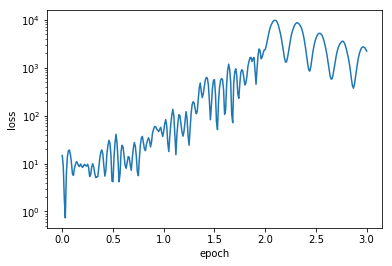

In [21]:
net.initialize(init.Normal(sigma=0.01), force_reinit=True)
trainer = gluon.Trainer(net.collect_params(), 'sgd',
                        {'learning_rate': 0.2, 'momentum': 0.99})
optimize(batch_size=10, trainer=trainer, num_epochs=3, decay_epoch=2,
            log_interval=10, features=features, labels=labels, net=net)

此时 loss 的值也发散了，考虑调小 momentum 的值

('w:', 
[[ 1.9991034 -3.001196 ]]
<NDArray 1x2 @cpu(0)>, '\nb:', 
[3.999783]
<NDArray 1 @cpu(0)>, '\n')


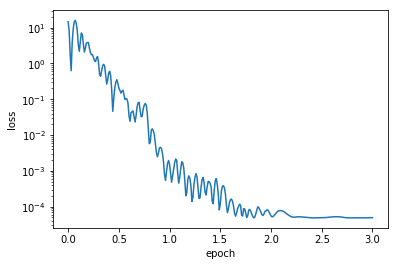

In [22]:
net.initialize(init.Normal(sigma=0.01), force_reinit=True)
trainer = gluon.Trainer(net.collect_params(), 'sgd',
                        {'learning_rate': 0.2, 'momentum': 0.9})
optimize(batch_size=10, trainer=trainer, num_epochs=3, decay_epoch=2,
            log_interval=10, features=features, labels=labels, net=net)

('w:', 
[[ 1.9996507 -2.9999607]]
<NDArray 1x2 @cpu(0)>, '\nb:', 
[4.0003195]
<NDArray 1 @cpu(0)>, '\n')


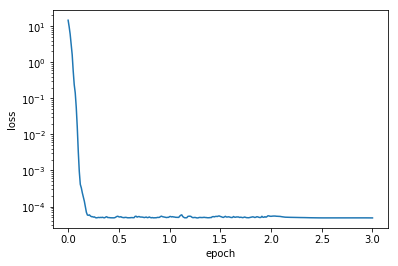

In [23]:
net.initialize(init.Normal(sigma=0.01), force_reinit=True)
trainer = gluon.Trainer(net.collect_params(), 'sgd',
                        {'learning_rate': 0.2, 'momentum': 0.4})
optimize(batch_size=10, trainer=trainer, num_epochs=3, decay_epoch=2,
            log_interval=10, features=features, labels=labels, net=net)

### 3.3 RMSProp

要把 RMSProp 作为优化函数的话就不能再在 Trainer 里面设置 sgd 了，把 sgd 替换为 'rmsprop' 就行。因为 RMSProp 相当于在训练过程中改变了不同特征的 learning rate，所以就不额外做 learning rate 的自动衰减了。

('w:', 
[[ 1.9504081 -2.8742104]]
<NDArray 1x2 @cpu(0)>, '\nb:', 
[3.8251412]
<NDArray 1 @cpu(0)>, '\n')


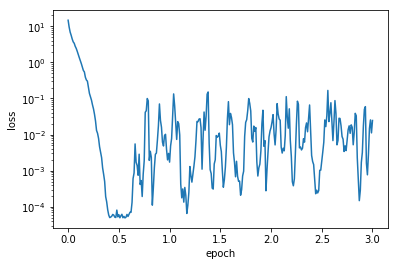

In [24]:
net.initialize(init.Normal(sigma=0.01), force_reinit=True)
trainer = gluon.Trainer(net.collect_params(), 'rmsprop',
                        {'learning_rate': 0.2, 'gamma1': 0.9})
optimize(batch_size=10, trainer=trainer, num_epochs=3, decay_epoch=None,
            log_interval=10, features=features, labels=labels, net=net)

loss 很快地降到了比较小的值之后开始剧烈的振荡。第一步可以考虑先把 learning rate 调小一些。

('w:', 
[[ 1.9846079 -2.9965956]]
<NDArray 1x2 @cpu(0)>, '\nb:', 
[3.9826496]
<NDArray 1 @cpu(0)>, '\n')


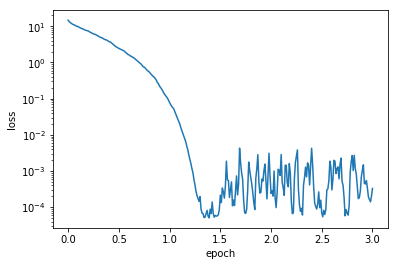

In [25]:
net.initialize(init.Normal(sigma=0.01), force_reinit=True)
trainer = gluon.Trainer(net.collect_params(), 'rmsprop',
                        {'learning_rate': 0.04, 'gamma1': 0.9})
optimize(batch_size=10, trainer=trainer, num_epochs=3, decay_epoch=None,
            log_interval=10, features=features, labels=labels, net=net)

将 learning rate 调小之后 loss 在快到2.5个 epoch 之后降到了最低然后开始振荡。此时我们可以考虑增大 gamma1

('w:', 
[[ 1.9994271 -3.0005052]]
<NDArray 1x2 @cpu(0)>, '\nb:', 
[4.0007706]
<NDArray 1 @cpu(0)>, '\n')


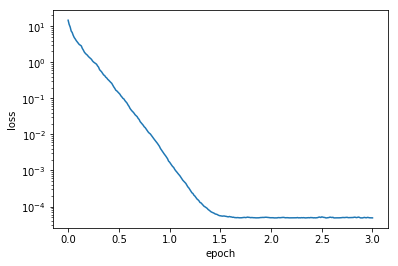

In [26]:
net.initialize(init.Normal(sigma=0.01), force_reinit=True)
trainer = gluon.Trainer(net.collect_params(), 'rmsprop',
                        {'learning_rate': 0.04, 'gamma1': 0.99})
optimize(batch_size=10, trainer=trainer, num_epochs=3, decay_epoch=None,
            log_interval=10, features=features, labels=labels, net=net)

('w:', 
[[ 1.9969263 -3.000254 ]]
<NDArray 1x2 @cpu(0)>, '\nb:', 
[3.9992645]
<NDArray 1 @cpu(0)>, '\n')


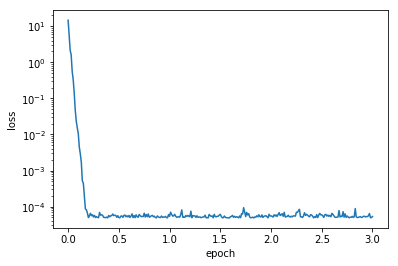

In [27]:
net.initialize(init.Normal(sigma=0.01), force_reinit=True)
trainer = gluon.Trainer(net.collect_params(), 'rmsprop',
                        {'learning_rate': 0.04, 'gamma1': 0.999})
optimize(batch_size=10, trainer=trainer, num_epochs=3, decay_epoch=None,
            log_interval=10, features=features, labels=labels, net=net)

# 3.4 Adam

Adam 这个方法大家一般都按照作者给的数值来设定除了 learning rate 之外的超参数，所以一般来说只需要设定一个值 learning rate 就可以了。同样，把前面是 sgd 部分替换成 'adam' 就行。

('w:', 
[[ 1.9969707 -3.0024967]]
<NDArray 1x2 @cpu(0)>, '\nb:', 
[3.9999366]
<NDArray 1 @cpu(0)>, '\n')


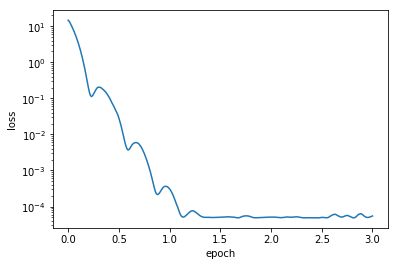

In [28]:
net.initialize(init.Normal(sigma=0.01), force_reinit=True)
trainer = gluon.Trainer(net.collect_params(), 'adam', {'learning_rate': 0.2})
optimize(batch_size=10, trainer=trainer, num_epochs=3, decay_epoch=None,
            log_interval=10, features=features, labels=labels, net=net)

('w:', 
[[ 2.0008457 -3.0010674]]
<NDArray 1x2 @cpu(0)>, '\nb:', 
[4.000152]
<NDArray 1 @cpu(0)>, '\n')


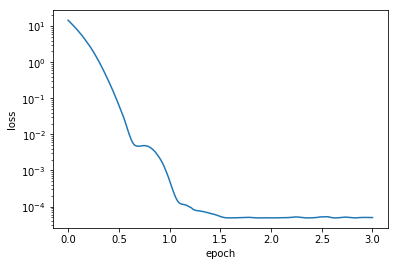

In [29]:
net.initialize(init.Normal(sigma=0.01), force_reinit=True)
trainer = gluon.Trainer(net.collect_params(), 'adam', {'learning_rate': 0.1})
optimize(batch_size=10, trainer=trainer, num_epochs=3, decay_epoch=None,
            log_interval=10, features=features, labels=labels, net=net)

('w:', 
[[ 1.9994774 -3.0004008]]
<NDArray 1x2 @cpu(0)>, '\nb:', 
[4.000499]
<NDArray 1 @cpu(0)>, '\n')


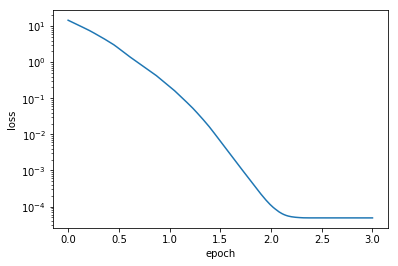

In [30]:
net.initialize(init.Normal(sigma=0.01), force_reinit=True)
trainer = gluon.Trainer(net.collect_params(), 'adam', {'learning_rate': 0.05})
optimize(batch_size=10, trainer=trainer, num_epochs=3, decay_epoch=None,
            log_interval=10, features=features, labels=labels, net=net)

('w:', 
[[ 1.9982024 -2.9976635]]
<NDArray 1x2 @cpu(0)>, '\nb:', 
[4.002177]
<NDArray 1 @cpu(0)>, '\n')


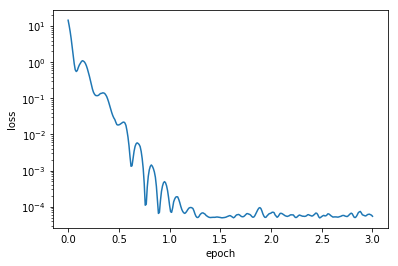

In [31]:
net.initialize(init.Normal(sigma=0.01), force_reinit=True)
trainer = gluon.Trainer(net.collect_params(), 'adam', {'learning_rate': 0.5})
optimize(batch_size=10, trainer=trainer, num_epochs=3, decay_epoch=None,
            log_interval=10, features=features, labels=labels, net=net)

调整 learning rate 还是会影响收敛速度、振荡情况等。